In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import sys
import os

# Add project root (one level above notebooks) to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from utils.features import add_lags_and_rolls, add_calendar
from utils.preprocessing import load_and_prepare

In [3]:
df = pd.read_csv('../data/uk_power_demand.csv')
df.head()

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,...,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW,NSL_FLOW,ELECLINK_FLOW,VIKING_FLOW,GREENLINK_FLOW
0,2025-01-01,1,21036,26215,19918,5405,6606,0,19180,0,...,-1518,-1026,1,-232,-386,-558,96,0,241,0
1,2025-01-01,2,21222,26063,20167,5358,6606,0,19180,0,...,-1513,-1023,1,-124,-282,-564,51,0,262,0
2,2025-01-01,3,21385,25734,20328,5237,6606,0,19180,0,...,-1428,-922,1,-119,-384,-205,62,0,414,0
3,2025-01-01,4,20473,24988,19460,5115,6606,0,19180,0,...,-1423,-915,0,-119,-334,-193,37,0,423,0
4,2025-01-01,5,19634,24912,18654,5080,6606,0,19180,0,...,-1539,-899,0,-119,-363,-622,-282,0,288,0


In [4]:
df.columns

Index(['SETTLEMENT_DATE', 'SETTLEMENT_PERIOD', 'ND', 'TSD',
       'ENGLAND_WALES_DEMAND', 'EMBEDDED_WIND_GENERATION',
       'EMBEDDED_WIND_CAPACITY', 'EMBEDDED_SOLAR_GENERATION',
       'EMBEDDED_SOLAR_CAPACITY', 'NON_BM_STOR', 'PUMP_STORAGE_PUMPING',
       'SCOTTISH_TRANSFER', 'IFA_FLOW', 'IFA2_FLOW', 'BRITNED_FLOW',
       'MOYLE_FLOW', 'EAST_WEST_FLOW', 'NEMO_FLOW', 'NSL_FLOW',
       'ELECLINK_FLOW', 'VIKING_FLOW', 'GREENLINK_FLOW'],
      dtype='object')

In [5]:
df['datetime'] = pd.to_datetime(df['SETTLEMENT_DATE']) 
df = df.set_index('datetime')
df = df.sort_index()

Text(0, 0.5, 'Demand (MW)')

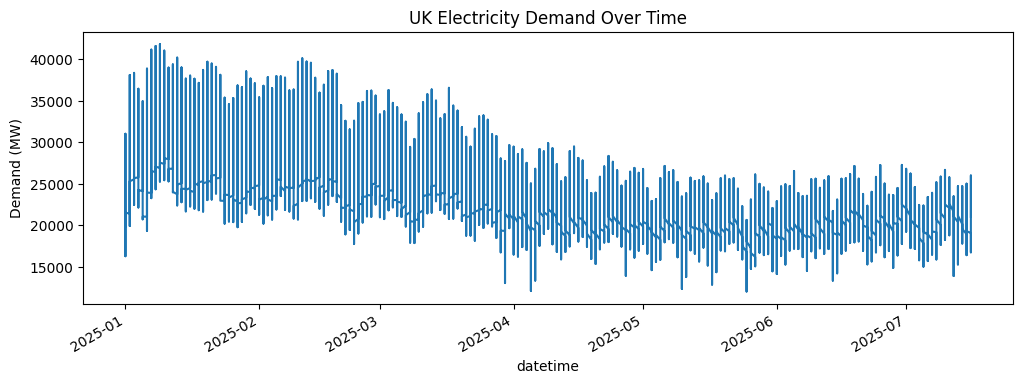

In [6]:
df['ENGLAND_WALES_DEMAND'].plot(figsize=(12, 4), title ='UK Electricity Demand Over Time') 
plt.ylabel('Demand (MW)')

Text(0, 0.5, 'Demand (MW)')

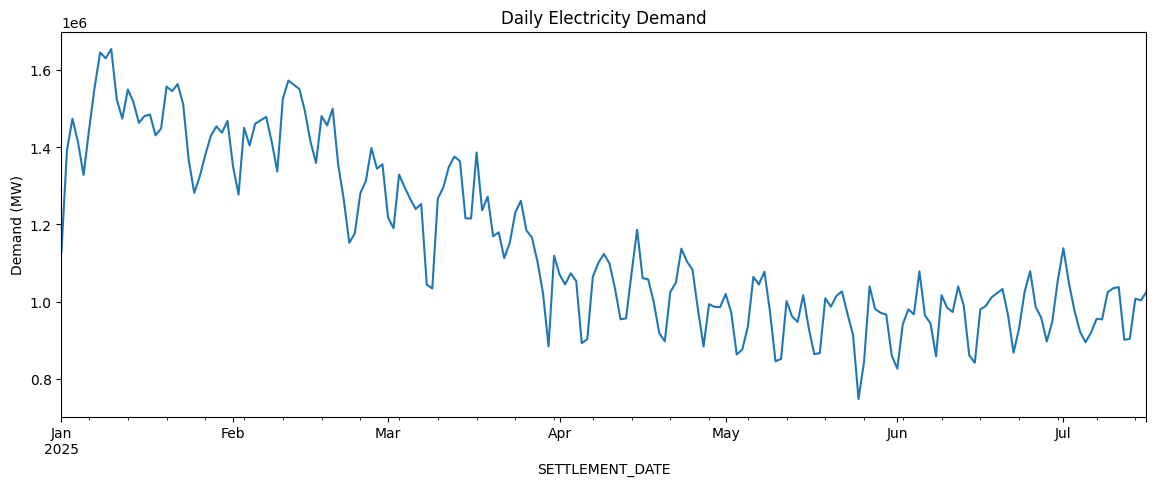

In [5]:
#df_daily = df.resample('D').sum()
#resampling to daily rather than like half hourly
import sys, os


# Load cleaned data
df_daily = load_and_prepare('../data/uk_power_demand.csv',
                            date_col='SETTLEMENT_DATE',
                            value_col='ENGLAND_WALES_DEMAND',
                            freq='D')

df_daily.head()

df_daily["ENGLAND_WALES_DEMAND"].plot(figsize=(14,5), title='Daily Electricity Demand')
plt.ylabel('Demand (MW)')

<Axes: title={'center': 'Average Demand by Day of Week'}, xlabel='weekday'>

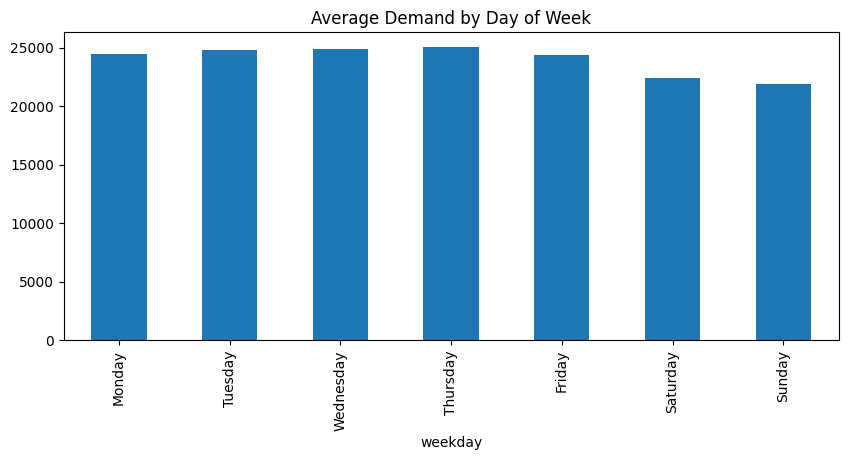

In [8]:
df['weekday'] = df.index.day_name()
df.groupby('weekday')['ENGLAND_WALES_DEMAND'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).plot(kind='bar', figsize=(10, 4), title='Average Demand by Day of Week')

<Axes: xlabel='datetime'>

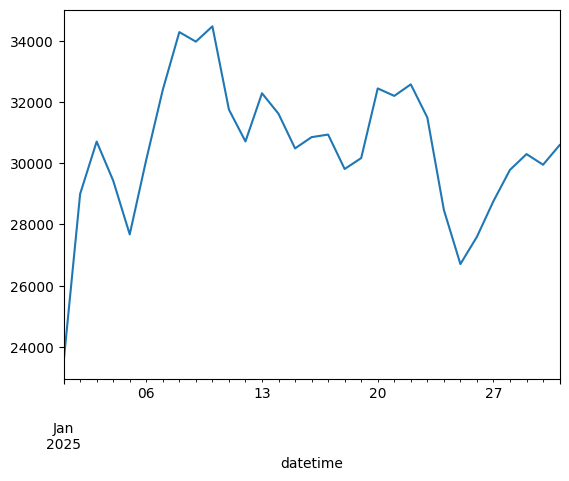

In [9]:
#shortening time period and using average instead of sum
df_onemonth = df[['ENGLAND_WALES_DEMAND']].resample('D').mean().loc['2025-01']
df_onemonth["ENGLAND_WALES_DEMAND"].plot()

<Axes: xlabel='datetime'>

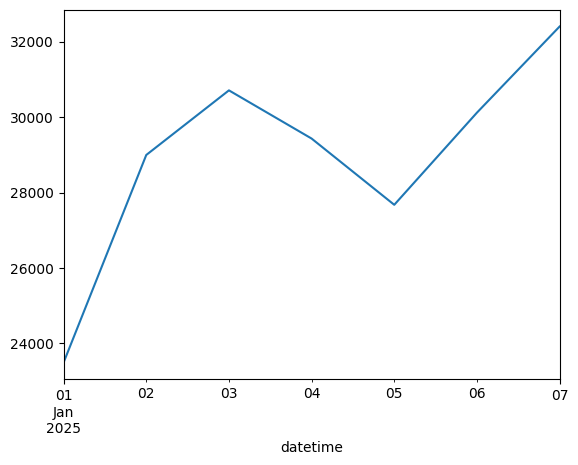

In [10]:
df_oneweek = df[['ENGLAND_WALES_DEMAND']].resample('D').mean().loc['2025-01-01':'2025-01-07']
df_oneweek["ENGLAND_WALES_DEMAND"].plot()

In [11]:
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='30min')
missing = date_range.difference(df.index)
print(f"Missing timestamps: {len(missing)}")


Missing timestamps: 9212


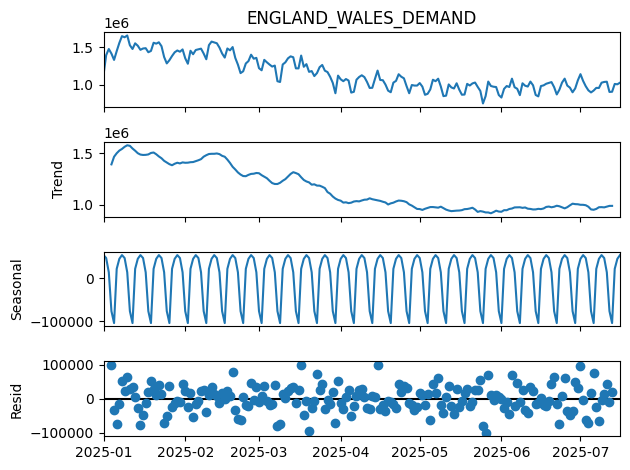

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_daily['ENGLAND_WALES_DEMAND'], model='additive', period=7)
decomposition.plot()
plt.show()

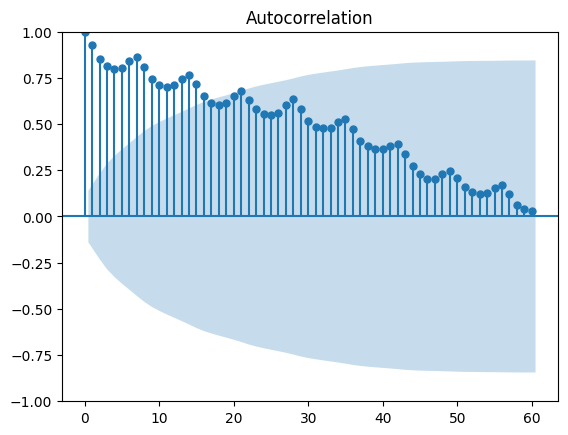

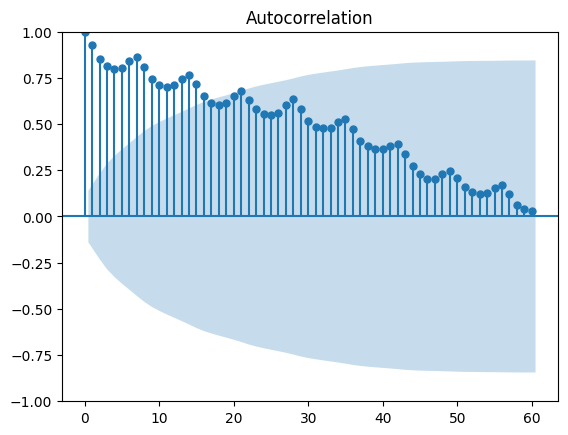

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_daily['ENGLAND_WALES_DEMAND'].dropna(), lags=60)


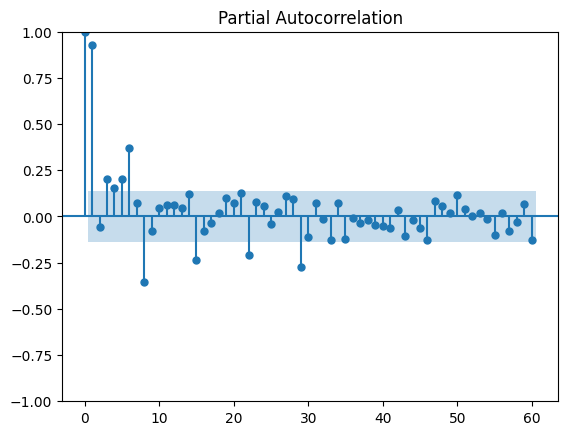

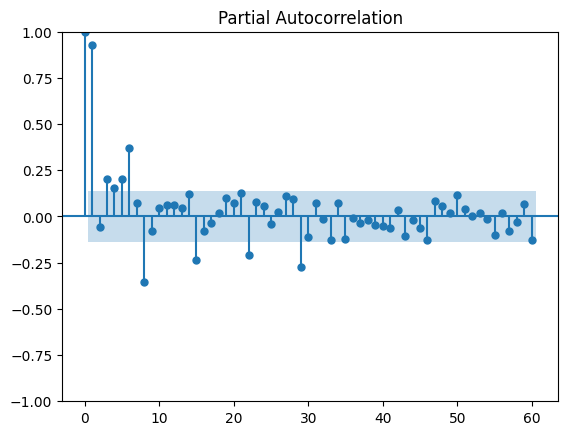

In [14]:
plot_pacf(df_daily['ENGLAND_WALES_DEMAND'].dropna(), lags=60)


In [95]:
from utils.features import add_lags_and_rolls, add_calendar

df_daily = add_lags_and_rolls(df_daily, 'ENGLAND_WALES_DEMAND', lags=(1,7,14), rolls=(3,7,14))
df_daily = add_calendar(df_daily)


In [66]:
# Yesterday's demand
#df_daily['lag1'] = df_daily['ENGLAND_WALES_DEMAND'].shift(1)

# Demand 7 days ago
#df_daily['lag7'] = df_daily['ENGLAND_WALES_DEMAND'].shift(7)

# Rolling averages (smooth history)
#df_daily['roll3'] = df_daily['ENGLAND_WALES_DEMAND'].rolling(3).mean()
#df_daily['roll7'] = df_daily['ENGLAND_WALES_DEMAND'].rolling(7).mean()

df_daily.head(10)


,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,...,lag7,roll3,roll7,weekday,is_weekend,month,season,is_holiday,lag14,roll14
datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-01,2025-01-012025-01-012025-01-012025-01-012025-0...,1176,1220564,1362706,1127794,173244,317088,4084,920640,0,...,NaN,1.127794e+06,1.127794e+06,2,0,1,1,1,NaN,1.127794e+06
2025-01-02,2025-01-022025-01-022025-01-022025-01-022025-0...,1176,1515273,1593268,1391757,80303,317088,49682,920640,0,...,NaN,1.259776e+06,1.259776e+06,3,0,1,1,0,NaN,1.259776e+06
2025-01-03,2025-01-032025-01-032025-01-032025-01-032025-0...,1176,1611248,1695232,1473925,69292,317088,46686,920640,0,...,NaN,1.331159e+06,1.331159e+06,4,0,1,1,0,NaN,1.331159e+06
2025-01-04,2025-01-042025-01-042025-01-042025-01-042025-0...,1176,1554406,1623480,1412632,49016,317088,11337,920640,0,...,NaN,1.426105e+06,1.351527e+06,5,1,1,1,0,NaN,1.351527e+06
2025-01-05,2025-01-052025-01-052025-01-052025-01-052025-0...,1176,1475393,1536168,1328385,117946,317088,4453,920640,0,...,NaN,1.404981e+06,1.346899e+06,6,1,1,1,0,NaN,1.346899e+06
2025-01-06,2025-01-062025-01-062025-01-062025-01-062025-0...,1176,1596686,1677618,1445573,171850,317088,18170,920640,0,...,NaN,1.395530e+06,1.363344e+06,0,0,1,1,0,NaN,1.363344e+06
2025-01-07,2025-01-072025-01-072025-01-072025-01-072025-0...,1176,1690219,1781944,1555124,134030,317088,43830,920640,4,...,NaN,1.443027e+06,1.390741e+06,1,0,1,1,0,NaN,1.390741e+06
2025-01-08,2025-01-082025-01-082025-01-082025-01-082025-0...,1176,1803557,1883993,1645561,61763,317088,12446,920640,0,...,1127794.0,1.548753e+06,1.464708e+06,2,0,1,1,0,NaN,1.422594e+06
2025-01-09,2025-01-092025-01-092025-01-092025-01-092025-0...,1176,1795075,1890310,1630578,76727,317088,55339,920640,0,...,1391757.0,1.610421e+06,1.498825e+06,3,0,1,1,0,NaN,1.445703e+06


In [57]:
# Weekday name & number
#df_daily['weekday'] = df_daily.index.weekday  # 0=Mon, 6=Sun
#df_daily['is_weekend'] = (df_daily['weekday'] >= 5).astype(int)

# Month & season

# Rough season buckets from month 1=Winter, 2=Spring, 3=Summer, 4=Autumn
# Formula: shift months so Dec->winter, then integer-divide by 3
#df_daily['month'] = df_daily.index.month
#df_daily['season'] = ((df_daily['month'] % 12 + 3) // 3)  # 1=Winter, 2=Spring, 3=Summer, 4=Autumn

#Extracts time of year signals that can drive demand (work/weekend cold/warm months)

In [26]:
import holidays
years = df_daily.index.year.unique()
uk_holidays = holidays.country_holidays('GB', years=years)  # Great Britain national holidays
# is_holiday: 1 if the date is in the holiday set, else 0
#df_daily['is_holiday'] = df_daily.index.normalize().isin(uk_holidays).astype(int)
# Cast index to pure dates so types match
df_daily['is_holiday'] = pd.Series(df_daily.index.date, index=df_daily.index).isin(uk_holidays).astype(int)
df_daily[df_daily['is_holiday'] == 1]

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,...,GREENLINK_FLOW,lag1,lag7,roll3,roll7,weekday,is_weekend,month,season,is_holiday
datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-01,2025-01-012025-01-012025-01-012025-01-012025-0...,1176,1220564,1362706,1127794,173244,317088,4084,920640,0,...,0,NaN,NaN,NaN,NaN,2,0,1,1,1
2025-04-18,2025-04-182025-04-182025-04-182025-04-182025-0...,1176,1110690,1173556,999165,110140,317088,83719,933600,0,...,-14497,1057540.0,1034066.0,1.039151e+06,1.041137e+06,4,0,4,2,1
2025-05-05,2025-05-052025-05-052025-05-052025-05-052025-0...,1176,1044440,1133401,934193,63497,317088,140628,898560,0,...,-24680,876039.0,993190.0,8.910107e+05,9.480441e+05,0,0,5,2,1
2025-05-26,2025-05-262025-05-262025-05-262025-05-262025-0...,1176,913130,1149638,845284,170506,317088,122012,933648,0,...,-21828,747397.0,1008456.0,8.355837e+05,9.289679e+05,0,0,5,2,1


In [67]:
#Training a SARIMA model which predicts electricity demand by looking at yesterday last week and seasonal patterns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Splitting the data into "training" (past) and "validation" (future)

split_date = df_daily.index[int(len(df_daily)*0.8)] #take 80% past, 20% future
train = df_daily.loc[:split_date].copy()            #everything up to split date
valid = df_daily.loc[split_date:].copy()            #everything after split date

# Define the SARIMA model

sarima = SARIMAX(
    endog=train['ENGLAND_WALES_DEMAND'],          # the demand series we want to predict
    order=(1,1,1),                # (p,d,q): handles short-term patterns + trend
    seasonal_order=(1,1,1,7),     # (P,D,Q,s): handles weekly seasonality (7 days)
    enforce_stationarity=False,   # don’t force strict mathematical rules
    enforce_invertibility=False   # same idea: more flexibility for learning
)

# p = how many past values to look at
# d = how many times to subtract previous values to remove trends
# q = how much it should use past forecast errors to improve itself

# Train (fit) the model on the training data

sarima_fit = sarima.fit(disp=False) #.fit() means: learn patterns from the training period

# Forecast into the validation period

sarima_forecast = sarima_fit.predict(
    start=valid.index[0],  # first date of the validation set
    end=valid.index[-1]    # last date of the validation set
)

# Measure how good the forecast is

sarima_mae = mean_absolute_error(valid['ENGLAND_WALES_DEMAND'], sarima_forecast)
print(f"SARIMA MAE: {sarima_mae} MW")

SARIMA MAE: 77526.97677743444 MW


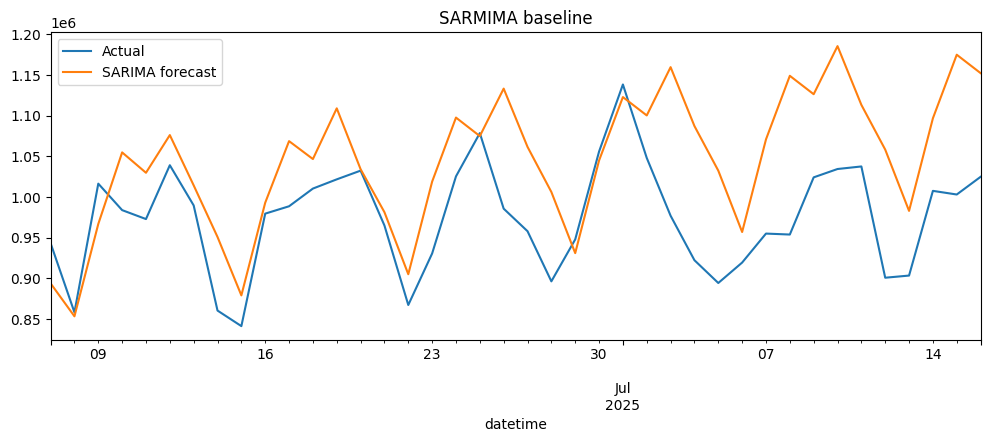

In [68]:
ax = valid['ENGLAND_WALES_DEMAND'].plot(figsize=(12,4), label='Actual') #plot real
sarima_forecast.plot(ax=ax, label='SARIMA forecast')                    #plot predicted
plt.legend()
plt.title('SARMIMA baseline')
plt.show()

In [69]:
# Train an XGBoost model (machine learninb@)

from xgboost import XGBRegressor 
from sklearn.model_selection import train_test_split

# Choose feature columns (the ones created earlier)

feature_cols = ['lag1','lag7','roll3','roll7','weekday','is_weekend','month','season','is_holiday']

# Drop rows with NaNs from lags/rolls at the start

data = df_daily[['ENGLAND_WALES_DEMAND'] + feature_cols].dropna().copy()

# Split into X (features) snd y (demand), keeping time alignment

X = data[feature_cols]
y = data['ENGLAND_WALES_DEMAND']

# Time-aware split: no shuffling

X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
y_train, y_test = y.loc[X_train.index], y.loc[X_test.index]

# Define and train the model

xgb = XGBRegressor(
    n_estimators=500,      # number of trees
    learning_rate=0.05,    # step size shrinkage, slower but more precise, how much should each guess be changed
    max_depth=6,           # tree depth (complexity control)
    subsample=0.9,         # row sampling for robustness, prevents overfitting. like only looks at .9 days
    colsample_bytree=0.9,  # feature sampling for robustness, only looks at .9 features
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)  # train model on training data

# Predict on the test slice
xgb_pred = xgb.predict(X_test)

# Evaluate
xgb_mae = mean_absolute_error(y_test, xgb_pred)
print(f"XGBoost MAE: {xgb_mae} MW")


XGBoost MAE: 29189.908203125 MW


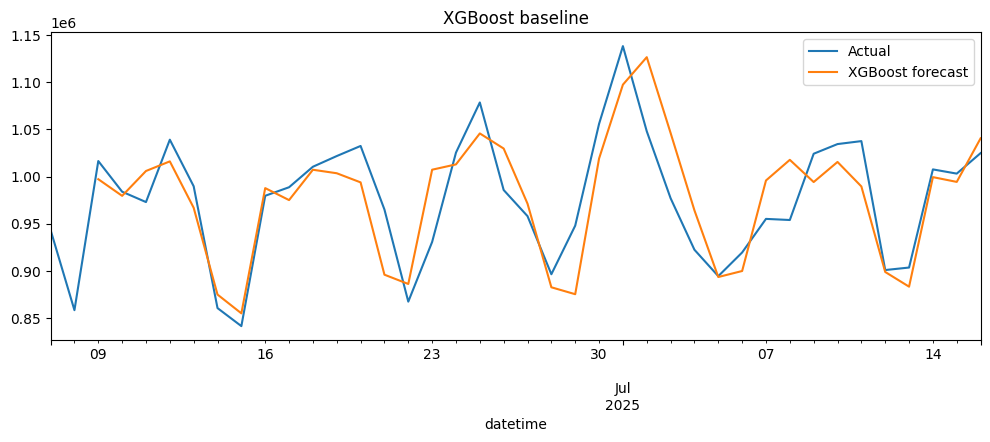

In [70]:
ax = valid['ENGLAND_WALES_DEMAND'].plot(figsize=(12,4), label='Actual') #plot real
pd.Series(xgb_pred, index=y_test.index).plot(ax=ax, label='XGBoost forecast')                     #plot predicted
plt.legend()
plt.title('XGBoost baseline')
plt.show()

In [71]:
# Backtesting (rolling forecasts over time) closer to reality because youre not training once and predicting for ever but retraining every so often as new data comes in

def backtest_xgb(df, feature_cols, target, step=14, train_size=0.6, model_kwargs=None):

    if model_kwargs is None:
        model_kwargs = dict(n_estimators=400, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)

    # Clean data

    data = df[[target] + feature_cols].dropna().copy()
    X_all, y_all = data[feature_cols], data[target]

    # Determine first training window

    n0 = int(len(X_all)*train_size)

    # Rolling forecast

    preds = []
    truth = []

    i = n0

    while i<len(X_all):

        # Train on all data up to i
        X_train, y_train = X_all.iloc[:i], y_all.iloc[:i]

        # Test on next 'step' days
        X_test, y_test = X_all.iloc[i:i+step], y_all.iloc[i:i+step]

        if len(X_test) == 0:
            break

        # Train and predict

        model = XGBRegressor(**model_kwargs)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        preds.extend(y_pred.tolist())
        truth.extend(y_test.tolist())

        i+=step

    return mean_absolute_error(truth, preds), pd.Series(preds, index=y_all.index[n0:n0+len(truth)])






In [72]:
bt_mae, bt_pred_series = backtest_xgb(
    df=df_daily,
    feature_cols=feature_cols,
    target='ENGLAND_WALES_DEMAND',
    step=14,        # forecast two weeks at a time
    train_size=0.6  # use 60% of history first
)

print(f"Backtest MAE: {bt_mae} MW")

Backtest MAE: 38869.36513157895 MW


<Axes: xlabel='datetime'>

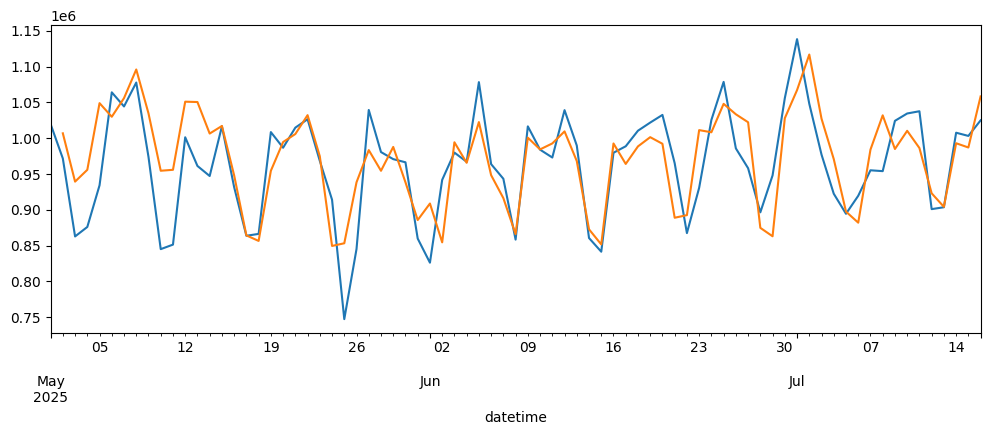

In [91]:
ax = df_daily['ENGLAND_WALES_DEMAND'].iloc[-len(bt_pred_series)*1-1:].plot(figsize=(12,4), label='Actual') #basically just show the last part of the data
bt_pred_series.plot(ax=ax, label='XGB Backtest Forecast')


Epoch 1/50


C:\Users\anjol\OneDrive\Scans\project\time-series-forecasting\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.4048 - val_loss: 0.1956
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3484 - val_loss: 0.1551
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2902 - val_loss: 0.1128
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2291 - val_loss: 0.0743
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1590 - val_loss: 0.0620
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1001 - val_loss: 0.1136
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1126 - val_loss: 0.1165
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1016 - val_loss: 0.0808
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0908 - val_loss: 0.0653
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0914 - val_loss: 0.0638
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0869 - val_loss: 0.0666
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0841 - val_loss: 0.0667
Epoch 13/50


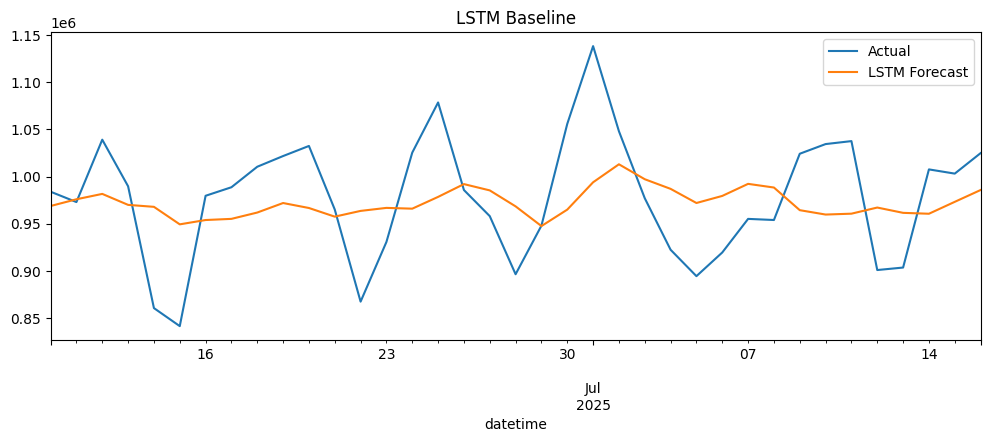

In [88]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error

# --- Day 2, Step 2c: Prepare Data for LSTM ---

# Select the target variable for forecasting
target_col = 'ENGLAND_WALES_DEMAND'
data = df_daily[['ENGLAND_WALES_DEMAND'] + feature_cols].dropna().copy()
y = data[target_col] # Retain the y variable with the correct index

# Normalize the data to a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[[target_col]]) # Pass the target column as a DataFrame

# Create sequences (time windows) for the LSTM model
# A common practice is to use a window of 7 days to predict the next day
timesteps = 7

X_lstm, y_lstm = [], []
for i in range(timesteps, len(scaled_data)):
    X_lstm.append(scaled_data[i-timesteps:i, 0])
    y_lstm.append(scaled_data[i, 0])

# Reshape the data for the LSTM input format [samples, timesteps, features]
X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

# --- Day 2, Step 2c: Split the data ---

# Time-aware split: No shuffling
# Get the index for the training and testing sets
split_index = int(len(X_lstm) * 0.8)
train_index = y.index[timesteps:split_index + timesteps]
test_index = y.index[split_index + timesteps:]

X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm[:split_index], y_lstm[split_index:]

# --- Day 2, Step 2c: Build and Compile the LSTM Model ---

# Define the model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], 1)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mae')

# --- Day 2, Step 2c: Train the LSTM Model ---

# Train the model on the training data
history = model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm),
    verbose=1
)

# --- Day 2, Step 2c: Make Predictions and Evaluate ---

# Make predictions on the test data
lstm_pred_scaled = model.predict(X_test_lstm)

# Invert the scaling to get the predictions in original units (MW)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
y_test_original = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Measure the forecast performance
lstm_mae = mean_absolute_error(y_test_original, lstm_pred)
print(f"LSTM MAE: {lstm_mae} MW")

# Plot the results
lstm_pred_series = pd.Series(lstm_pred.flatten(), index=test_index)
ax = df_daily['ENGLAND_WALES_DEMAND'].loc[test_index].plot(figsize=(12, 4), label='Actual')
lstm_pred_series.plot(ax=ax, label='LSTM Forecast')
plt.legend()
plt.title('LSTM Baseline')
plt.show()